# Time Series Prediction with Long Short Term Merory Networks ($LSTM$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-07 18:11:04

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Gathering Dependencies

_Importing Required Libraries_

In [10]:
pip install hampel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_TURKEY EARTHQUAKE_

In [12]:
data = pd.read_csv("/content/drive/MyDrive/new/datasets/eq.csv")
training_set = data.iloc[:, 4]
print(training_set)

0       4.4
1       5.2
2       4.8
3       4.4
4       5.7
       ... 
6569    4.5
6570    4.0
6571    4.4
6572    4.1
6573    4.0
Name: Magnitude, Length: 6574, dtype: float64


## Preprocessing the Data

In [13]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix >= len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(training_set, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

Streaming output truncated to the last 5000 lines.
[4.5 4.6 4.2] 4.8
[4.6 4.2 4.8] 5.5
[4.2 4.8 5.5] 4.1
[4.8 5.5 4.1] 4.5
[5.5 4.1 4.5] 7.2
[4.1 4.5 7.2] 5.1
[4.5 7.2 5.1] 5.3
[7.2 5.1 5.3] 4.7
[5.1 5.3 4.7] 4.3
[5.3 4.7 4.3] 4.5
[4.7 4.3 4.5] 4.0
[4.3 4.5 4. ] 4.8
[4.5 4.  4.8] 4.4
[4.  4.8 4.4] 4.2
[4.8 4.4 4.2] 4.1
[4.4 4.2 4.1] 5.2
[4.2 4.1 5.2] 4.4
[4.1 5.2 4.4] 4.3
[5.2 4.4 4.3] 5.1
[4.4 4.3 5.1] 4.1
[4.3 5.1 4.1] 4.0
[5.1 4.1 4. ] 4.3
[4.1 4.  4.3] 4.5
[4.  4.3 4.5] 4.6
[4.3 4.5 4.6] 4.2
[4.5 4.6 4.2] 4.3
[4.6 4.2 4.3] 4.2
[4.2 4.3 4.2] 4.4
[4.3 4.2 4.4] 4.2
[4.2 4.4 4.2] 4.4
[4.4 4.2 4.4] 5.1
[4.2 4.4 5.1] 4.3
[4.4 5.1 4.3] 4.3
[5.1 4.3 4.3] 4.2
[4.3 4.3 4.2] 4.3
[4.3 4.2 4.3] 4.5
[4.2 4.3 4.5] 4.5
[4.3 4.5 4.5] 4.7
[4.5 4.5 4.7] 4.4
[4.5 4.7 4.4] 4.5
[4.7 4.4 4.5] 4.1
[4.4 4.5 4.1] 4.3
[4.5 4.1 4.3] 4.3
[4.1 4.3 4.3] 4.5
[4.3 4.3 4.5] 4.6
[4.3 4.5 4.6] 5.0
[4.5 4.6 5. ] 4.2
[4.6 5.  4.2] 4.7
[5.  4.2 4.7] 4.3
[4.2 4.7 4.3] 4.2
[4.7 4.3 4.2] 4.3
[4.3 4.2 4.3] 4.7
[4.2 4.3 4.7]

## Train and Test Split

In [14]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(5256, 1, 3) (5256,) (1315, 1, 3) (1315,)


## Model ($LSTM$)

In [15]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
n_steps = 3

X, y = split_sequence(training_set, n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), verbose=1, shuffle=False)

Epoch 1/500
83/83 [==============================] - 11s 48ms/step - loss: 6.4643 - val_loss: 0.1502
Epoch 2/500
83/83 [==============================] - 2s 18ms/step - loss: 0.3210 - val_loss: 0.1322
Epoch 3/500
83/83 [==============================] - 1s 17ms/step - loss: 0.3076 - val_loss: 0.1310
Epoch 4/500
83/83 [==============================] - 2s 18ms/step - loss: 0.3070 - val_loss: 0.1305
Epoch 5/500
83/83 [==============================] - 2s 22ms/step - loss: 0.3017 - val_loss: 0.1290
Epoch 6/500
83/83 [==============================] - 2s 26ms/step - loss: 0.2986 - val_loss: 0.1285
Epoch 7/500
83/83 [==============================] - 2s 25ms/step - loss: 0.3007 - val_loss: 0.1281
Epoch 8/500
83/83 [==============================] - 1s 17ms/step - loss: 0.2925 - val_loss: 0.1273
Epoch 9/500
83/83 [==============================] - 2s 20ms/step - loss: 0.2881 - val_loss: 0.1288
Epoch 10/500
83/83 [==============================] - 1s 18ms/step - loss: 0.2798 - val_loss: 0.126

## Metrics ($LSTM$)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX, verbose=0)
rmse = np.sqrt(mean_squared_error(testY, yhat))
mae = np.sqrt(mean_absolute_error(testY, yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 0.357
Test MAE: 0.496


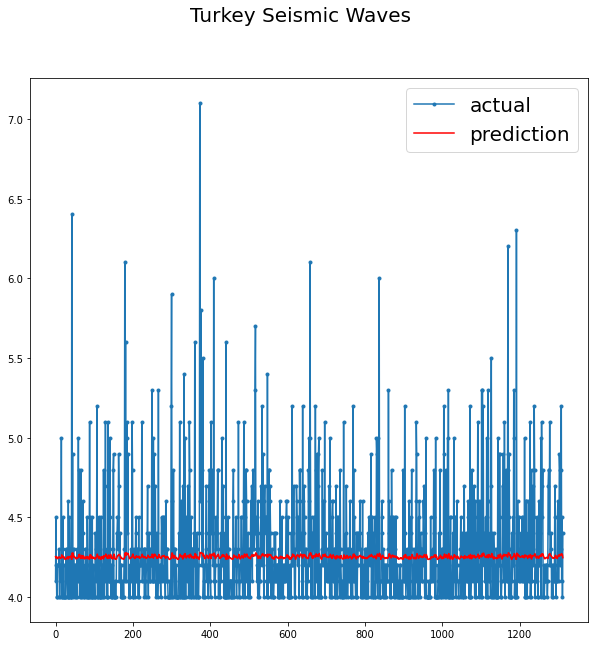

In [17]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
anurag=[x for x in range(1313)]
plt.plot(anurag, testY[:1313], marker='.', label="actual")
plt.plot(anurag, yhat[:1313], 'r', label="prediction")
plt.suptitle('Turkey Seismic Waves', fontsize=20)
plt.legend(fontsize=20)
plt.show()